# Final Project

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## GNN

In [3]:
# df_reddit_title = pd.read_csv("data/soc-redditHyperlinks-title.tsv", sep= '\t', nrows= 5000)
df_reddit_body_raw = pd.read_csv("data/soc-redditHyperlinks-body.tsv", sep= '\t')
df_reddit_body_raw.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08..."
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049..."
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082..."
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0...."
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0...."


In [4]:
df_reddit_body = df_reddit_body_raw.copy(deep= True)
properties_split = df_reddit_body["PROPERTIES"].str.split(",", expand=True)
z_properties_list = []

for ii in range(properties_split.shape[1]):
    df_reddit_body[f"PROPERTY_{ii}"] = properties_split[ii].astype(float)

    property_z = (df_reddit_body[f"PROPERTY_{ii}"] - df_reddit_body[f"PROPERTY_{ii}"].mean()) / df_reddit_body[f"PROPERTY_{ii}"].std()
    z_properties_list.append(property_z.rename(f"PROPERTY_{ii}_z"))



df_reddit_body = pd.concat([df_reddit_body] + z_properties_list, axis=1)
print(df_reddit_body.shape)
df_reddit_body.head()

(286561, 178)


,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,PROPERTY_0,PROPERTY_1,PROPERTY_2,PROPERTY_3,...,PROPERTY_76_z,PROPERTY_77_z,PROPERTY_78_z,PROPERTY_79_z,PROPERTY_80_z,PROPERTY_81_z,PROPERTY_82_z,PROPERTY_83_z,PROPERTY_84_z,PROPERTY_85_z
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",345.0,298.0,0.756522,0.017391,...,3.898207,1.382879,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",101.0,98.0,0.742574,0.019802,...,-0.877308,3.295571,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",85.0,85.0,0.752941,0.023529,...,-0.877308,-0.666433,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",1124.0,949.0,0.772242,0.001779,...,1.286597,0.571693,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,6.627112,0.493551
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",715.0,622.0,0.777622,0.006993,...,0.276775,0.819318,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,1.048653


Encode subreddit names

In [4]:
node_encoder = LabelEncoder()
all_subreddits = pd.concat([df_reddit_body["SOURCE_SUBREDDIT"], df_reddit_body["TARGET_SUBREDDIT"]])
node_encoder.fit(all_subreddits)

source_series = pd.Series(node_encoder.transform(df_reddit_body["SOURCE_SUBREDDIT"]))
target_series = pd.Series(node_encoder.transform(df_reddit_body["TARGET_SUBREDDIT"]))

df_reddit_body = pd.concat([df_reddit_body,source_series.rename("SOURCE"), target_series.rename("TARGET")], axis=1)
df_reddit_body.head()

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,PROPERTIES,PROPERTY_0,PROPERTY_1,PROPERTY_2,PROPERTY_3,...,PROPERTY_78_z,PROPERTY_79_z,PROPERTY_80_z,PROPERTY_81_z,PROPERTY_82_z,PROPERTY_83_z,PROPERTY_84_z,PROPERTY_85_z,SOURCE,TARGET
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,"345.0,298.0,0.75652173913,0.0173913043478,0.08...",345.0,298.0,0.756522,0.017391,...,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618,17033,30615
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,"101.0,98.0,0.742574257426,0.019801980198,0.049...",101.0,98.0,0.742574,0.019802,...,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618,31606,28627
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,"85.0,85.0,0.752941176471,0.0235294117647,0.082...",85.0,85.0,0.752941,0.023529,...,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,-0.431618,15247,3550
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,"1124.0,949.0,0.772241992883,0.0017793594306,0....",1124.0,949.0,0.772242,0.001779,...,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,6.627112,0.493551,21054,5265
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,"715.0,622.0,0.777622377622,0.00699300699301,0....",715.0,622.0,0.777622,0.006993,...,-0.307649,-0.50953,-0.25306,-0.265003,-0.262798,-0.364137,-0.282640,1.048653,23489,12173


Create edge index

In [5]:
edge_index = torch.tensor(df_reddit_body[["SOURCE", "TARGET"]].values.T, dtype=torch.long)
print(edge_index.shape)

torch.Size([2, 286561])


Create edge data attributes using z-score normalized properties

In [6]:
feature_columns = [f"PROPERTY_{ii}_z" for ii in range(properties_split.shape[1])]
edge_attr = torch.tensor(df_reddit_body[feature_columns].values, dtype=torch.float)

Make labels for each edge based on link sentiment

In [7]:
edge_label = torch.tensor(df_reddit_body["LINK_SENTIMENT"].values, dtype=torch.float)

Arbitrary node data

In [8]:
num_nodes = len(node_encoder.classes_)
x = torch.eye(num_nodes)

Create PyTorch Geometric Data

In [9]:
data = Data(
    x= x,
    edge_index= edge_index,
    edge_attr= edge_attr,
    y= edge_label,
)

Create GNN

In [ ]:
class GNN(nn.Module):
    def __init__(self, node_in_dim, node_hidden_dim, edge_in_dim, hidden_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.gnn1 = GCNConv(node_in_dim, node_hidden_dim)
        self.gnn2 = GCNConv(node_hidden_dim, node_hidden_dim)

        self.edge_mlp1 = nn.Sequential(
            nn.Linear(2*node_hidden_dim + edge_in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, x, edge_index, edge_attr):
        h = self.gnn1(x, edge_index)
        h = F.relu(h)
        h = self.gnn2(h, edge_index)

        src, dst = edge_index
        h_src = h[src]
        h_dst = h[dst]

        edge_input = torch.cat([h_src, edge_attr, h_dst], dim=1)
        edge_logits = self.edge_mlp1(edge_input).squeeze()
        return edge_logits


In [11]:
model = GNN(
    node_in_dim= data.x.shape[1],
    node_hidden_dim= 64,
    edge_in_dim= data.edge_attr.shape[1],
    hidden_dim= 64,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [12]:
num_edges = data.edge_index.size(1)
all_edge_indices = torch.arange(num_edges)
train_idx, test_idx = train_test_split(
    all_edge_indices.numpy(),
    test_size= 0.3,
    random_state= 2025,
    stratify= data.y.numpy()
)

train_idx = torch.tensor(train_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)
print(df_reddit_body["LINK_SENTIMENT"].iloc[train_idx].value_counts())
print(df_reddit_body["LINK_SENTIMENT"].iloc[test_idx].value_counts())


LINK_SENTIMENT
 1    185843
-1     14749
Name: count, dtype: int64
LINK_SENTIMENT
 1    79648
-1     6321
Name: count, dtype: int64


In [13]:
def train_GNN():
    model.train()
    optimizer.zero_grad()

    logits = model(data.x, data.edge_index, data.edge_attr)
    preds = logits[train_idx]
    labels = data.y[train_idx].float()
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    return loss.item()

def test_GNN():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, data.edge_attr)
        preds = torch.sigmoid(logits[test_idx]) > 0.5
        labels = data.y[test_idx]

        accuracy = (preds == labels).sum().item()/len(labels)
        return accuracy

In [14]:
epochs = 200

losses = []
accs = []
rec_epoch = []

for epoch in range(1, epochs+1):
    loss = train_GNN()
    if epoch == 1 or epoch % 10 == 0:
        acc = test_GNN()
        rec_epoch.append(epoch)
        losses.append(loss)
        accs.append(acc)
        print(f"Epoch {epoch}/{epochs} | Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

Epoch 1/200 | Loss: 0.6814 | Test Accuracy: 0.9219
Epoch 10/200 | Loss: 0.3541 | Test Accuracy: 0.8920
Epoch 20/200 | Loss: 0.3254 | Test Accuracy: 0.8880
Epoch 30/200 | Loss: 0.2945 | Test Accuracy: 0.8819
Epoch 40/200 | Loss: 0.2704 | Test Accuracy: 0.8669
Epoch 50/200 | Loss: 0.2486 | Test Accuracy: 0.8622
Epoch 60/200 | Loss: 0.2220 | Test Accuracy: 0.8647
Epoch 70/200 | Loss: 0.1671 | Test Accuracy: 0.8225
Epoch 80/200 | Loss: 0.0513 | Test Accuracy: 0.8620
Epoch 90/200 | Loss: -0.5797 | Test Accuracy: 0.8274
Epoch 100/200 | Loss: -2.1841 | Test Accuracy: 0.8656
Epoch 110/200 | Loss: -8.5992 | Test Accuracy: 0.8752
Epoch 120/200 | Loss: -23.9857 | Test Accuracy: 0.8918
Epoch 130/200 | Loss: -66.0986 | Test Accuracy: 0.9041
Epoch 140/200 | Loss: -112.3390 | Test Accuracy: 0.9180
Epoch 150/200 | Loss: -231.0990 | Test Accuracy: 0.9057
Epoch 160/200 | Loss: -437.7367 | Test Accuracy: 0.8998
Epoch 170/200 | Loss: -778.4154 | Test Accuracy: 0.9116
Epoch 180/200 | Loss: -1295.9546 | Tes

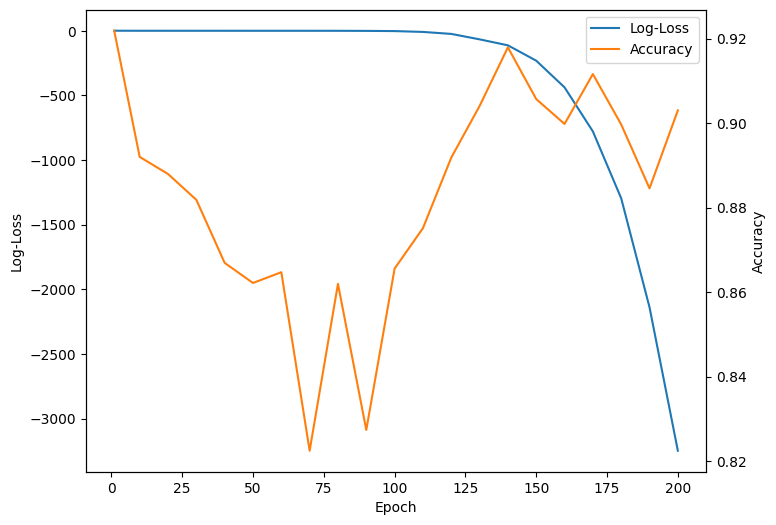

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))
l1, = ax1.plot(rec_epoch, losses, label="Log-Loss", color='tab:blue')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Log-Loss")

ax2 = ax1.twinx()
l2, = ax2.plot(rec_epoch, accs, label="Accuracy", color='tab:orange')
ax2.set_ylabel("Accuracy")

lines = [l1, l2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")
plt.savefig("reddit_gnn_loss_acc.png", dpi=300, bbox_inches='tight')
plt.show()